In [1]:
!pip install chardet silence_tensorflow
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install transformers shap lime

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4464 sha256=8ad58bcc545ff5c32b6783bedf6dc0c73b860e9306d75a0e32511a228254d799
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=cb411cce5857b142e64aa25634f431e9285729982a09587068f6a7212bf997bd
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.12.0
4.33.0


In [2]:
train_path = "/kaggle/input/disease-classification-from-patients-comments/HealthCare Data.csv"
test_path = "/kaggle/input/disease-classification-from-patients-comments/Test_data.csv"

In [3]:
import chardet 
train_file = open(train_path, 'rb')
test_file = open(test_path, 'rb')
train_encod = chardet.detect(train_file.read())
test_encod = chardet.detect(test_file.read()) 

In [4]:
df_train = pd.read_csv(train_path, encoding=train_encod["encoding"])
df_test = pd.read_csv(test_path, encoding=test_encod["encoding"])

In [5]:
df_train

Patient_comment  Patient_Category
0                       When I remember her I feel down    Emotional pain
1     When I carry heavy things I feel like breaking...  Hair falling out
2             there is too much pain when i move my arm       Heart hurts
3     My son had his lip pierced and it is swollen a...    Infected wound
4                My muscles in my lower back are aching    Infected wound
...                                                 ...               ...
6656  I feel a burning sensation in my guts about 2 ...      Stomach ache
6657     I have a split on my thumb that will not heal.        Open wound
6658                I feel a lot of pain in the joints.        Joint pain
6659        The area around my heart doesn't feel good.       Heart hurts
6660                  I complain alot with skin allergy        Skin issue

[6661 rows x 2 columns]

In [6]:
df_train.isna().sum()

Patient_comment     0
Patient_Category    0
dtype: int64

<Axes: xlabel='Patient_Category'>

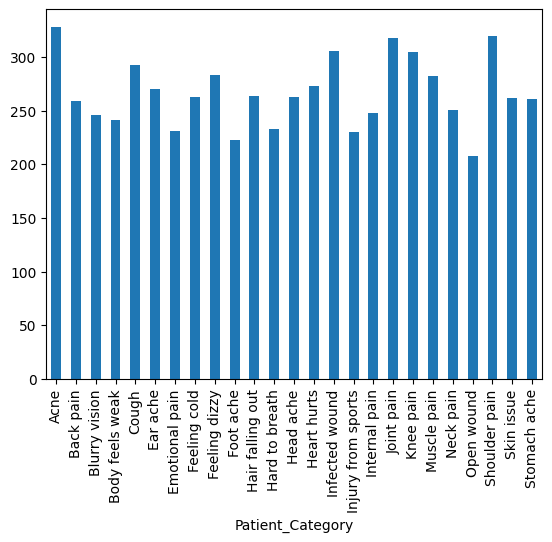

In [7]:
df_train.groupby('Patient_Category').Patient_comment.count().plot.bar(ylim = 0)

<Axes: xlabel='Patient_Category'>

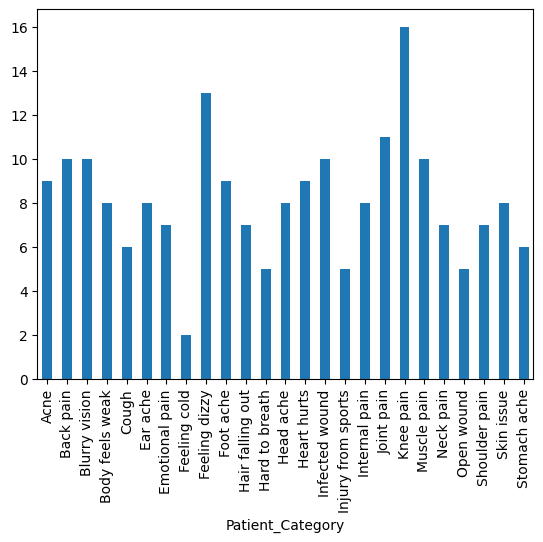

In [8]:
df_test.groupby('Patient_Category').Patient_comment.count().plot.bar(ylim = 0)

In [9]:
doctor_types = {
    'Emotional pain':'Psychiatrist', 
    'Hair falling out':'Dermatologist', 
    'Heart hurts':'Cardiologist',
    'Infected wound':'Surgeon', 
    'Foot ache':'Rheumatologist', 
    'Shoulder pain':'Rheumatologist/Gastro-enterologist',
    'Injury from sports':'Rheumatologist', 
    'Skin issue':'Dermatologist',
    'Stomach ache':'Gastro-enterologist', 
    'Knee pain':'Orthopedist',
    'Joint pain':'Orthopedist', 
    'Hard to breath':'Respirologist', 
    'Head ache':'Neurologist/Gastro-enterologist', 
    'Body feels weak':'General-Physicians',
    'Feeling dizzy':'General-Physicians', 
    'Back pain':'Orthopedist', 
    'Open wound':'Surgeon', 
    'Internal pain':'Gastro-enterologist',
    'Blurry vision':'Ophthalmologist',
    'Acne':'Dermatologist', 
    'Muscle pain':'Rheumatologist' ,
    'Neck pain':'Rheumatologist/Orthopedist',
    'Cough':'ENT Specialist',
    'Ear ache':'ENT Specialist', 
    'Feeling cold':'ENT Specialist'
}

In [10]:
df_train['specialist_type'] = df_train['Patient_Category'].replace(doctor_types, inplace=False)
df_test['specialist_type'] = df_test['Patient_Category'].replace(doctor_types, inplace=False)

In [11]:
df_train

Patient_comment  Patient_Category  \
0                       When I remember her I feel down    Emotional pain   
1     When I carry heavy things I feel like breaking...  Hair falling out   
2             there is too much pain when i move my arm       Heart hurts   
3     My son had his lip pierced and it is swollen a...    Infected wound   
4                My muscles in my lower back are aching    Infected wound   
...                                                 ...               ...   
6656  I feel a burning sensation in my guts about 2 ...      Stomach ache   
6657     I have a split on my thumb that will not heal.        Open wound   
6658                I feel a lot of pain in the joints.        Joint pain   
6659        The area around my heart doesn't feel good.       Heart hurts   
6660                  I complain alot with skin allergy        Skin issue   

          specialist_type  
0            Psychiatrist  
1           Dermatologist  
2            Cardiologist  
3                 Surgeon  
4                 Surgeon  
...                   ...  
6656  Gastro-enterologist  
6657              Surgeon  
6658          Orthopedist  
6659         Cardiologist  
6660        Dermatologist  

[6661 rows x 3 columns]

In [12]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()

df_train['specialist_type'] = encoder.fit_transform(df_train['specialist_type'].to_numpy())
df_test['specialist_type'] = encoder.transform(df_test['specialist_type'].to_numpy())

# Revert the encoded labels back to original labels
original_labels = np.unique(encoder.inverse_transform(df_train['specialist_type'])).tolist()

In [14]:
df_train['text'] = df_train['Patient_comment']
df_train['target'] = df_train['specialist_type']
df_test['text'] = df_test['Patient_comment']
df_test['target'] = df_test['specialist_type']

In [15]:
train = df_train.drop(['Patient_comment','specialist_type','Patient_Category'], axis=1)
test = df_test.drop(['Patient_comment','specialist_type','Patient_Category'], axis=1)

In [16]:
train

text  target
0                       When I remember her I feel down       8
1     When I carry heavy things I feel like breaking...       1
2             there is too much pain when i move my arm       0
3     My son had his lip pierced and it is swollen a...      13
4                My muscles in my lower back are aching      13
...                                                 ...     ...
6656  I feel a burning sensation in my guts about 2 ...       3
6657     I have a split on my thumb that will not heal.      13
6658                I feel a lot of pain in the joints.       7
6659        The area around my heart doesn't feel good.       0
6660                  I complain alot with skin allergy       1

[6661 rows x 2 columns]

In [17]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

## Tokenization

In [18]:
seq_len = max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [19]:
size

291

In [20]:
labels.shape

(6661, 14)

## Model Development

In [22]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''
from transformers import AutoTokenizer, AutoConfig
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
attention_layer = tf.keras.layers.Attention()([lstm, lstm])

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(14, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
291/291 [==============================] - ETA: 0s - loss: 0.7932 - categorical_accuracy: 0.7994
Epoch 1: loss improved from inf to 0.79317, saving model to model.h5
291/291 [==============================] - 166s 419ms/step - loss: 0.7932 - categorical_accuracy: 0.7994 - val_loss: 0.0813 - val_categorical_accuracy: 0.9795
Epoch 2/50
291/291 [==============================] - ETA: 0s - loss: 0.0571 - categorical_accuracy: 0.9882
Epoch 2: loss improved from 0.79317 to 0.05709, saving model to model.h5
291/291 [==============================] - 112s 385ms/step - loss: 0.0571 - categorical_accuracy: 0.9882 - val_loss: 0.0121 - val_categorical_accuracy: 0.9990
Epoch 3/50
291/291 [==============================] - ETA: 0s - loss: 0.0421 - categorical_accuracy: 0.9893
Epoch 3: loss improved from 0.05709 to 0.04208, saving model to model.h5
291/291 [==============================] - 112s 384ms/step - loss: 0.0421 - categorical_accuracy: 0.9893 - val_loss: 0.0363 - val_categorical_a

In [23]:
!zip -r file.zip /kaggle/working/model.h5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/model.h5 (deflated 27%)


## Model Architecture

In [24]:
bert_model = model
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 152)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 152)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 152,                                           

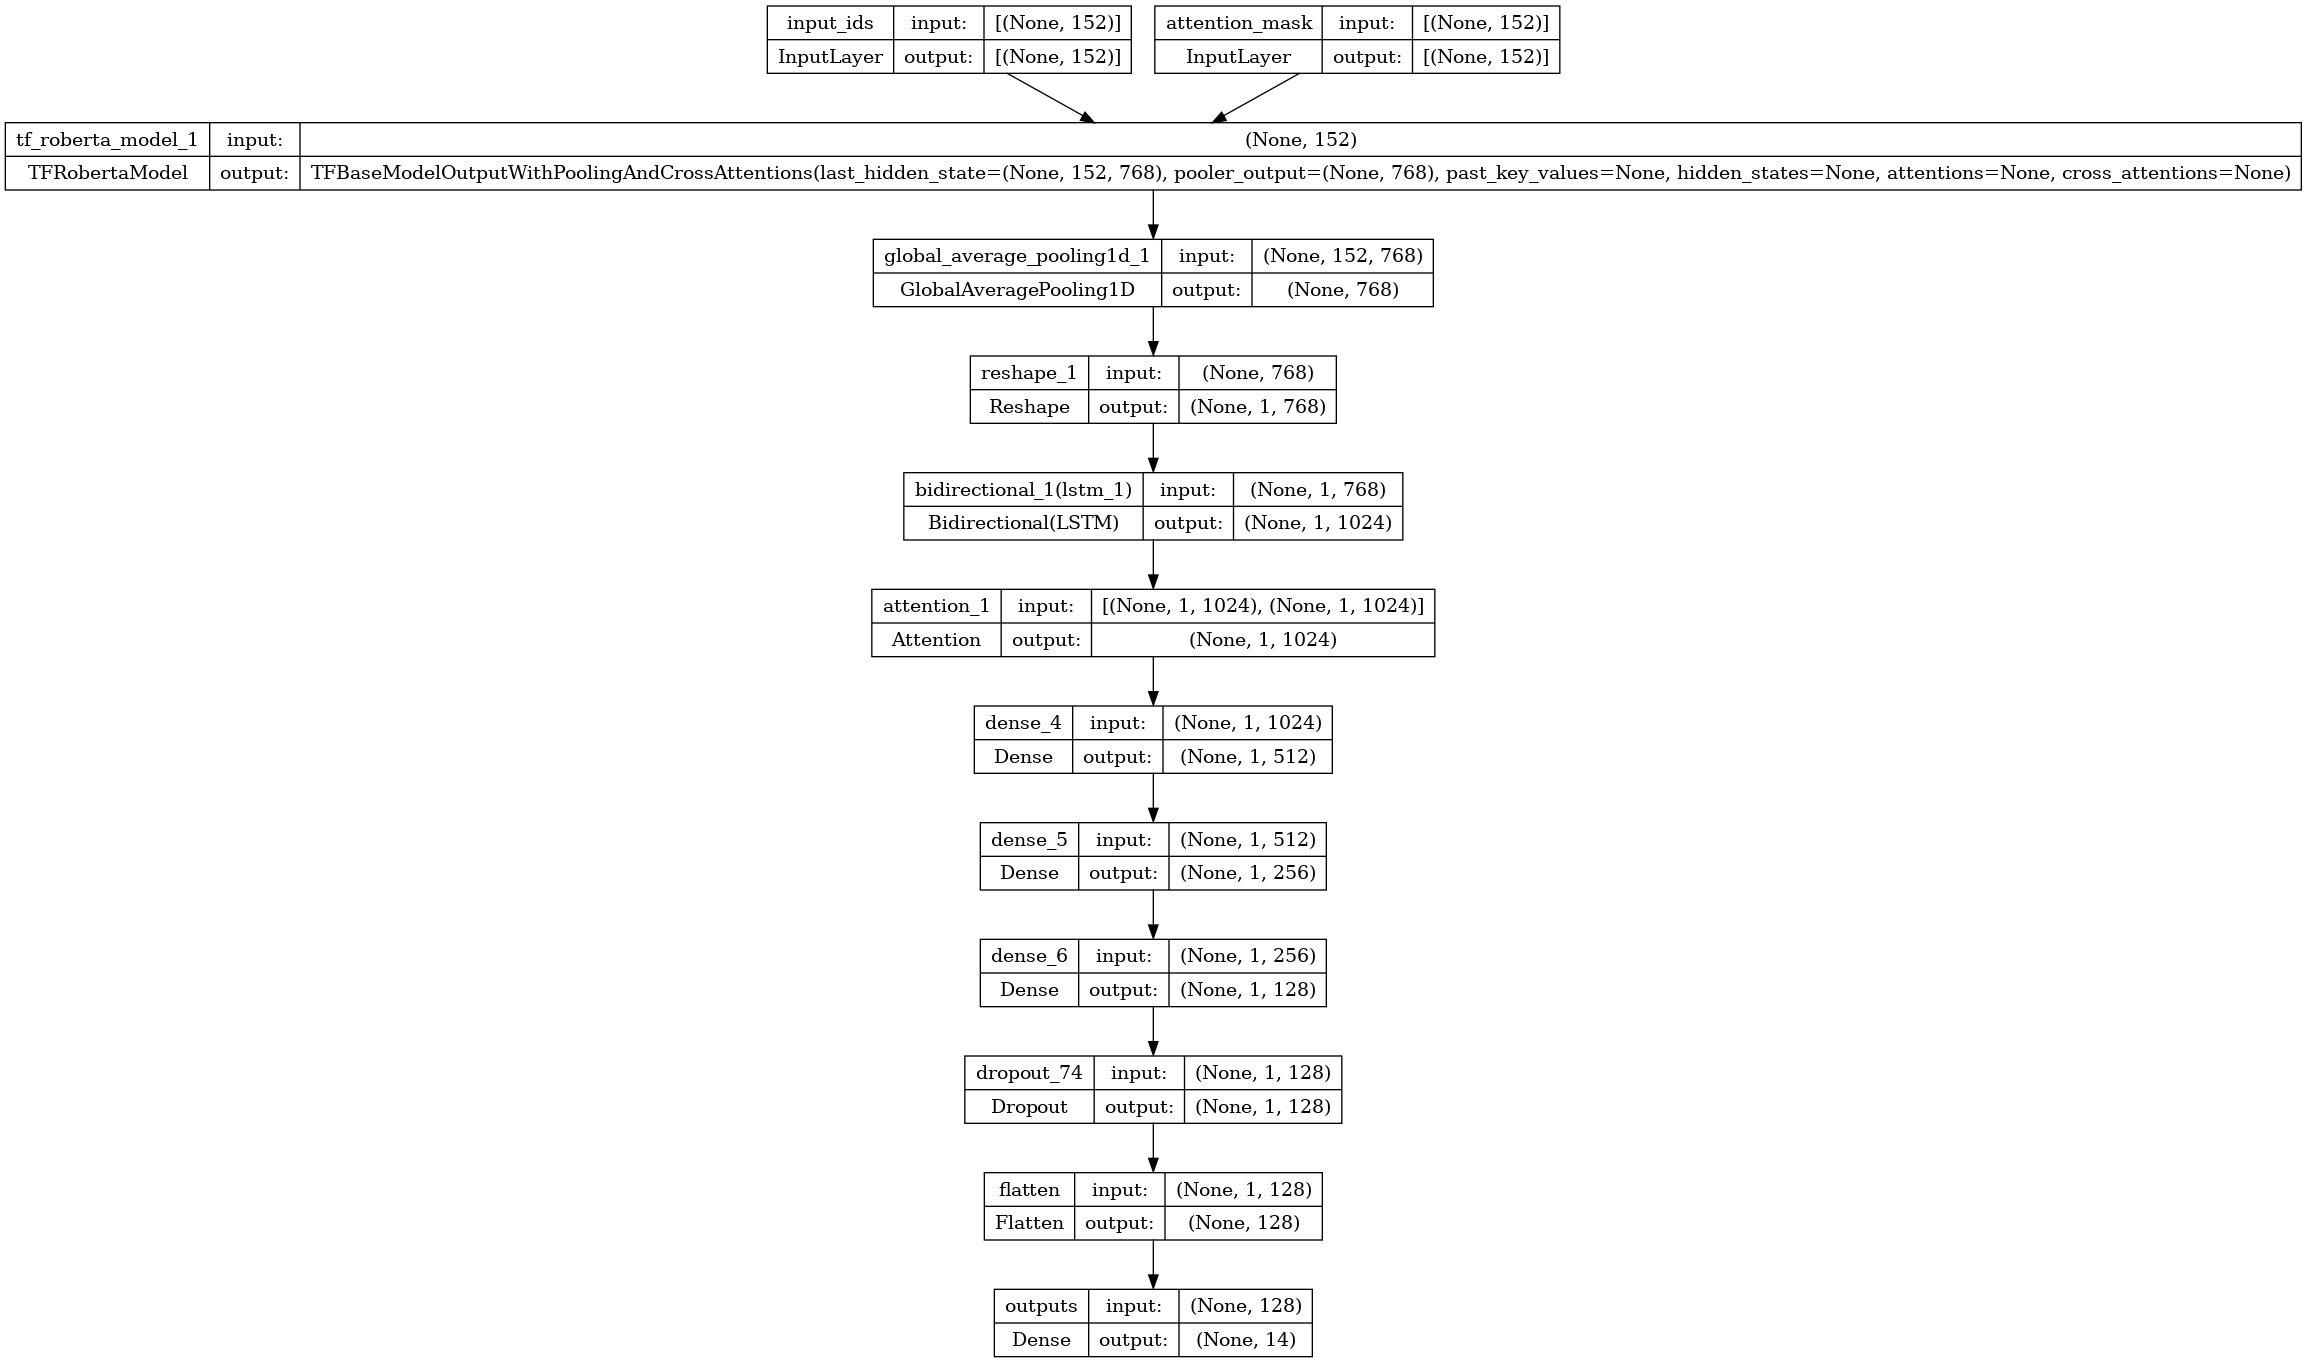

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(bert_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Model Evaluation

In [25]:
# For Data Visualization
!pip install plotly wordcloud
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


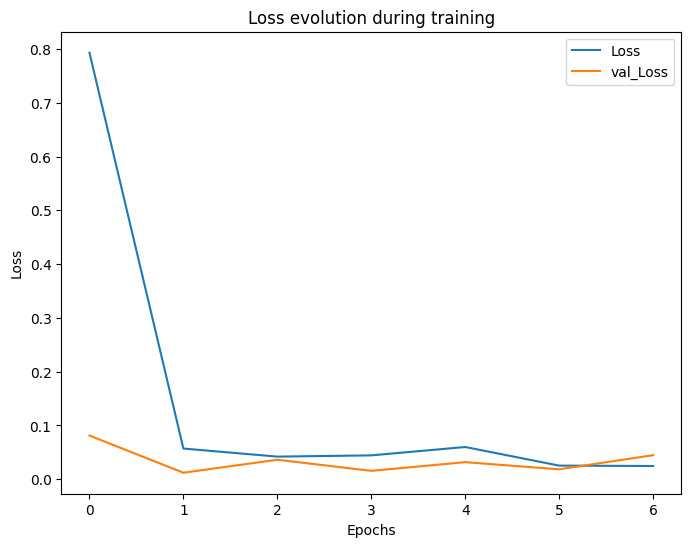

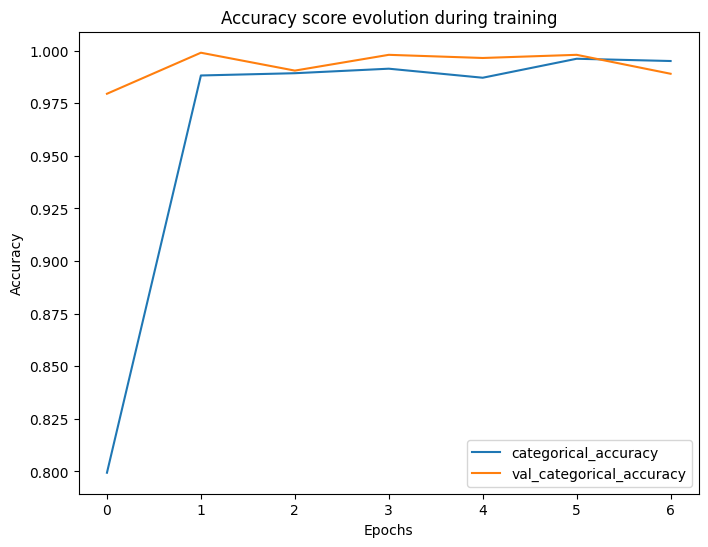

In [26]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')
    
plot_learning_evolution(history)

In [27]:
bert_model.evaluate(val_ds)

125/125 [==============================] - 14s 111ms/step - loss: 0.0132 - categorical_accuracy: 0.9990


[0.013191559351980686, 0.9990000128746033]

In [28]:
bert_model.evaluate(train_ds)

291/291 [==============================] - 32s 111ms/step - loss: 0.0184 - categorical_accuracy: 0.9981


[0.01843918487429619, 0.9980670213699341]

In [29]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

text  target  prediction
0                    I have muscle pain in my left leg      11          10
1    I have cut my finger because of playing footba...      10          10
2    I have acne in my face and other problems in m...       1           1
3                      I have a strange rash on my arm      10           1
4              I have a sharp pain in my lower stomach       3           3
..                                                 ...     ...         ...
199                   I feel dizzy whenever I stand up       4           4
200  Annoyance starts suddenly often after an injur...       7           7
201               I feel pain in my eyes I can see fog       6           6
202                                    Cant keep focus       5           5
203        I feel fluid trying to come up when I cough       2           2

[204 rows x 3 columns]

In [30]:
labels=original_labels
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

                                    precision    recall  f1-score   support

                      Cardiologist       1.00      0.89      0.94         9
                     Dermatologist       0.92      0.96      0.94        24
                    ENT Specialist       0.89      1.00      0.94        16
               Gastro-enterologist       1.00      1.00      1.00        14
                General-Physicians       0.95      0.95      0.95        21
   Neurologist/Gastro-enterologist       1.00      1.00      1.00         8
                   Ophthalmologist       1.00      1.00      1.00        10
                       Orthopedist       1.00      0.97      0.99        37
                      Psychiatrist       1.00      1.00      1.00         7
                     Respirologist       1.00      1.00      1.00         5
                    Rheumatologist       0.96      0.92      0.94        24
Rheumatologist/Gastro-enterologist       1.00      0.86      0.92         7
        Rhe

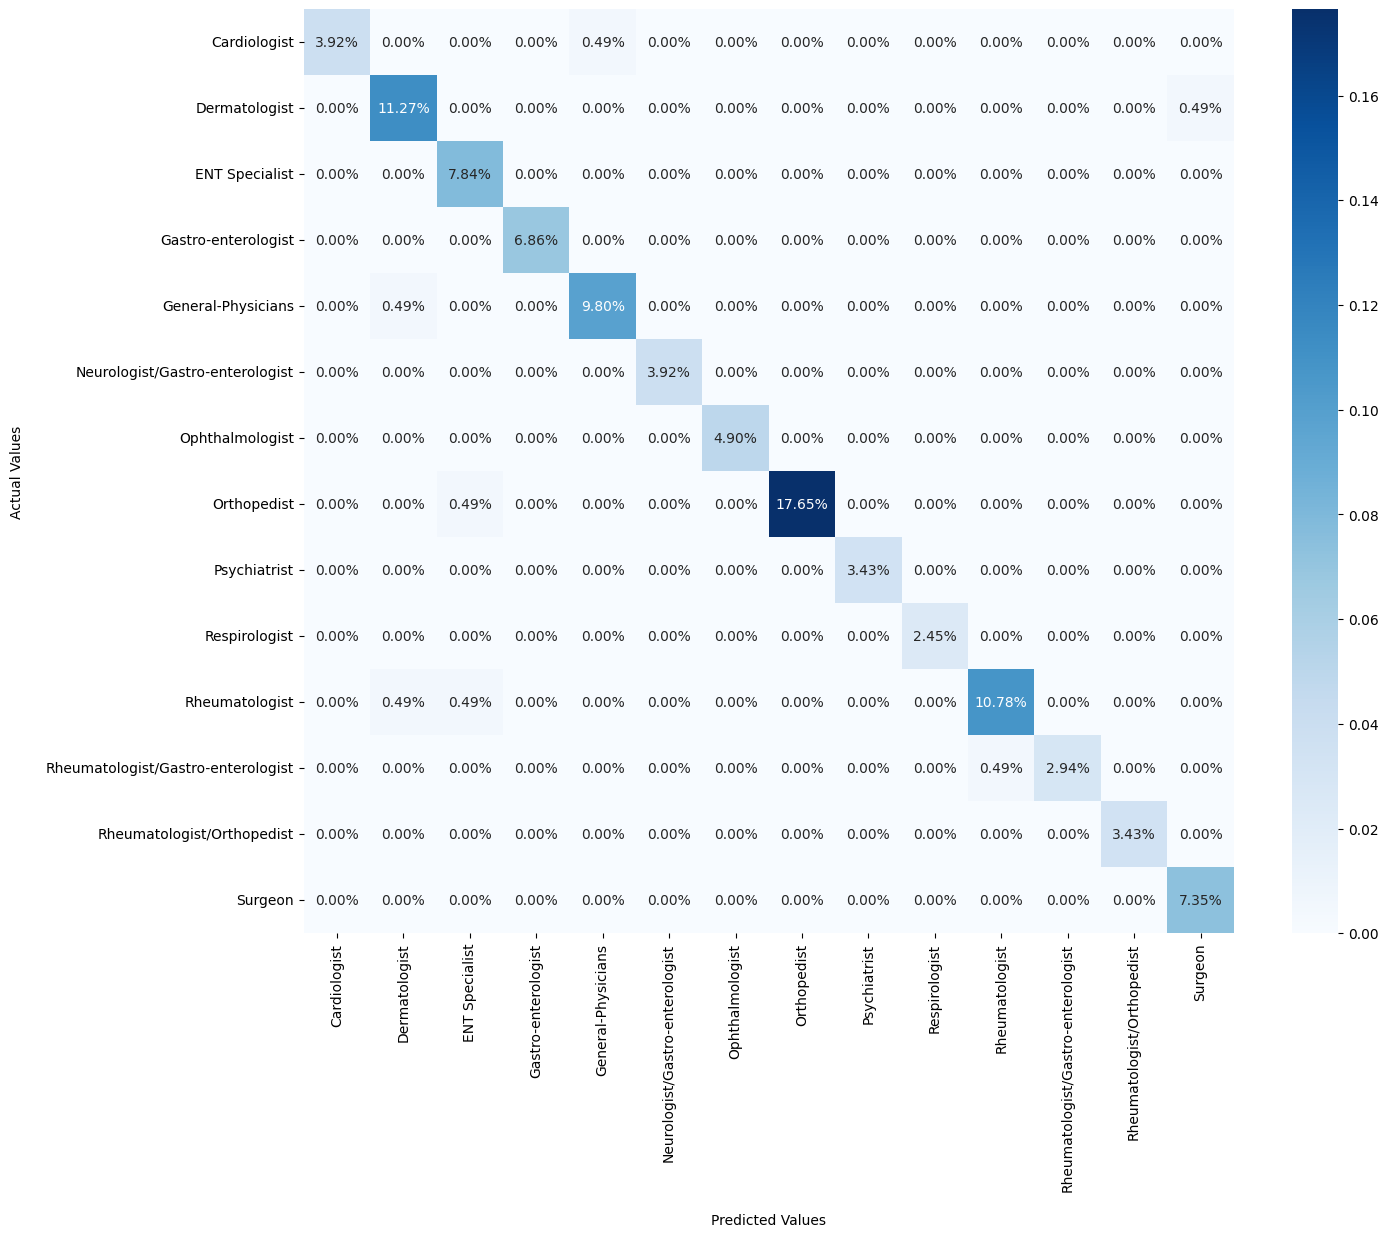

In [36]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(15,12))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)
# Rotate the x-axis labels
ax.set_xticklabels(original_labels, rotation=90)
# Rotate the y-axis labels
ax.set_yticklabels(original_labels, rotation=0)

plt.savefig('cm.png')
plt.show()

## SHAP

In [43]:
test3 = test[test['target']==2]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])
#test3[21:29] negative
#test3[47:54] neutral
test3[19:26] # positive
import shap 
import scipy.special

def predictor(x):
    input_ids = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['input_ids']
    attention_mask = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['attention_mask']
    outputs = model.predict([input_ids, attention_mask])
    probas = tf.nn.softmax(outputs).numpy()
    val = scipy.special.logit(probas[:,1])
    return val

def f_batch(x):
    val = np.array([])
    for i in x:
        val = np.append(val, predictor(i))
    return val

explainer_roberta = shap.Explainer(f_batch, tokenizer)

shap_values = explainer_roberta(test3['text'][0:-1].tolist())


0 I have a cold and it makes me cough alot
1 I have a dry throat
2 Im not hearing well I have problem with my ear
3 I have an ear ache that wont go away I dont have a cold or headache or any other symptoms Just an earache
4 My left ear is ok but the right one feels like its being stabbed with a nail
5 I was diagnosed with B 12 deficiency anemia which explains why I always felt cold
6 Every time I take a deep breath I start coughing
7 my child has cough all night she cant sleep
8 I have a lot of mucus when I cough
9 i have a problem in my middle ear made by infection
10 I m feeling cold though the temperature is high
11 I get an ear ache when it is cold
12 Im not hearing well I have problem with my ear
13 my ear hurts me badly
14 The pain in my ear is unbearable
15 I feel fluid trying to come up when I cough
1/1 [==============================] - 0s 45ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Partition explainer:   7%|▋         | 1/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


Partition explainer:  20%|██        | 3/15 [00:21<00:19,  1.66s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Partition explainer:  27%|██▋       | 4/15 [00:31<00:55,  5.07s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Partition explainer:  33%|███▎      | 5/15 [01:16<03:20, 20.06s/it]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/342 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


Partition explainer:  40%|████      | 6/15 [01:42<03:18, 22.08s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/306 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


Partition explainer:  47%|████▋     | 7/15 [02:05<02:58, 22.33s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Partition explainer:  53%|█████▎    | 8/15 [02:15<02:08, 18.29s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/110 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


Partition explainer:  60%|██████    | 9/15 [02:23<01:30, 15.13s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


Partition explainer:  67%|██████▋   | 10/15 [02:33<01:07, 13.50s/it]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/156 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Partition explainer:  73%|███████▎  | 11/15 [02:44<00:51, 12.77s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/110 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


Partition explainer:  80%|████████  | 12/15 [02:52<00:34, 11.39s/it]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


Partition explainer:  87%|████████▋ | 13/15 [03:02<00:21, 10.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


Partition explainer:  93%|█████████▎| 14/15 [03:12<00:10, 10.65s/it]

1/1 [==============================] - 0s 47ms/step


Partition explainer: 100%|██████████| 15/15 [03:16<00:00,  8.46s/it]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/72 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Partition explainer: 16it [03:21, 13.44s/it]                        


In [44]:
shap.plots.text(shap_values)

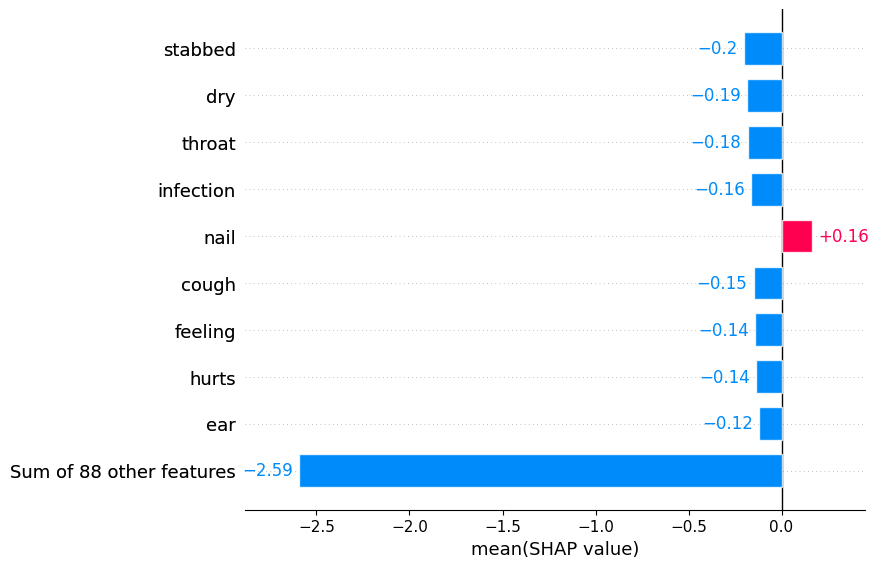

In [45]:
%matplotlib inline
shap.plots.bar(shap_values.mean(0))
plt.show()

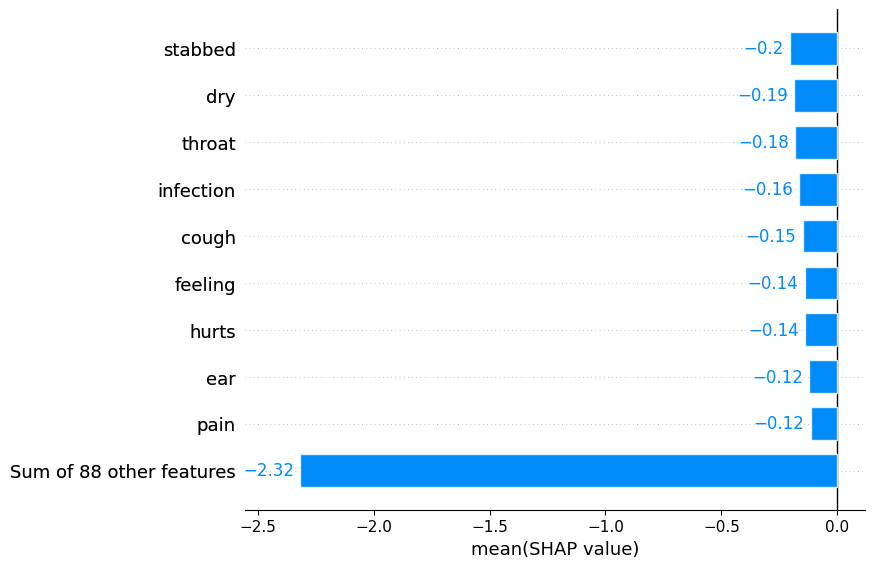

In [46]:
# we can sort the bar chart in decending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort)

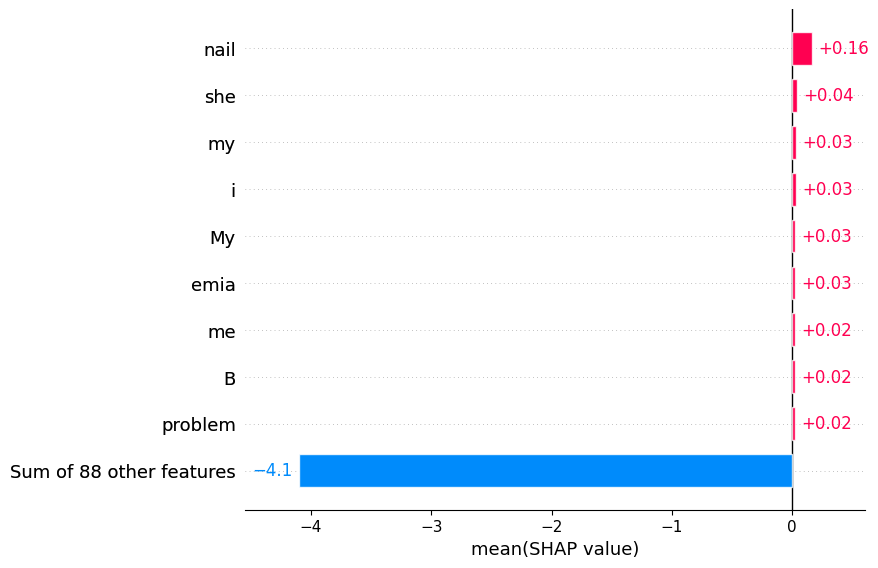

In [47]:
# ...or acending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort.flip)

## LIME

In [40]:
test3 = test[test['target']==2]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])

0 I have a cold and it makes me cough alot
1 I have a dry throat
2 Im not hearing well I have problem with my ear
3 I have an ear ache that wont go away I dont have a cold or headache or any other symptoms Just an earache
4 My left ear is ok but the right one feels like its being stabbed with a nail
5 I was diagnosed with B 12 deficiency anemia which explains why I always felt cold
6 Every time I take a deep breath I start coughing
7 my child has cough all night she cant sleep
8 I have a lot of mucus when I cough
9 i have a problem in my middle ear made by infection
10 I m feeling cold though the temperature is high
11 I get an ear ache when it is cold
12 Im not hearing well I have problem with my ear
13 my ear hurts me badly
14 The pain in my ear is unbearable
15 I feel fluid trying to come up when I cough


In [41]:
# 0 -> Neg, 1 -> Neu, 2 -> Pos
test3 = test[test['target']==2]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])
idx = 3

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

for ind, (i, row) in enumerate(test3.iterrows()):
    if ind == idx:
        print(row.text)
        tokens = prep_data(row['text'])

# We choose a sample from test set

test_text = np.array(test3['text'])
test_class = np.array(test3['target'])
text_sample = test_text[idx]
class_names = original_labels
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])
def predict_fn(x):    
    x =  prep_data(x)
    return model.predict(x)

print(text_sample)
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, predict_fn, num_features=12, top_labels=3)
exp.show_in_notebook(text=text_sample)

0 I have a cold and it makes me cough alot
1 I have a dry throat
2 Im not hearing well I have problem with my ear
3 I have an ear ache that wont go away I dont have a cold or headache or any other symptoms Just an earache
4 My left ear is ok but the right one feels like its being stabbed with a nail
5 I was diagnosed with B 12 deficiency anemia which explains why I always felt cold
6 Every time I take a deep breath I start coughing
7 my child has cough all night she cant sleep
8 I have a lot of mucus when I cough
9 i have a problem in my middle ear made by infection
10 I m feeling cold though the temperature is high
11 I get an ear ache when it is cold
12 Im not hearing well I have problem with my ear
13 my ear hurts me badly
14 The pain in my ear is unbearable
15 I feel fluid trying to come up when I cough
I have an ear ache that wont go away I dont have a cold or headache or any other symptoms Just an earache
1/1 [==============================] - 4s 4s/step
Probability = [[0.    0. 

In [42]:
test3 = test[test['target']==3]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])
idx = 3

for ind, (i, row) in enumerate(test3.iterrows()):
    if ind == idx:
        print(row.text)
        tokens = prep_data(row['text'])

# We choose a sample from test set

test_text = np.array(test3['text'])
test_class = np.array(test3['target'])
text_sample = test_text[idx]
class_names = original_labels
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])


print(text_sample)
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, predict_fn, num_features=12, top_labels=3)
exp.show_in_notebook(text=text_sample)

0 I have a sharp pain in my lower stomach
1 I feel a sharp pain in my stomach
2 I have a pain internal
3 i have pain but i cant specify place
4 i have a hard pain in my stomach
5 My body aches on the inside between my hips and shoulders
6 i feel pain in my stomach
7 I have a pain internal
8 I feel aching on my insides
9 I often get a stomach ache after I eat I havent been able to pinpoint which foods might be the trigger
10 I feel so sore in my stomach area
11 I feel pain inside and I can not identify it
12 I have an indigestion
13 i feel pain in my body
i have pain but i cant specify place
1/1 [==============================] - 0s 46ms/step
Probability = [[0.001 0.    0.002 0.996 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   ]]
True class: Gastro-enterologist
i have pain but i cant specify place
1/1 [==============================] - 0s 45ms/step
Probability = [[0.001 0.    0.002 0.996 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   ]]
True class: Gastro-enterolo